In [3]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Common_Functions as cf 
from mpl_toolkits import mplot3d
import matplotlib
#matplotlib.rcParams.update({'legend.fontsize': 12})
matplotlib.rcdefaults
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from scipy import stats

In [4]:


# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.Session(config=config))

In [5]:
df_pions = np.array(pd.read_csv('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/testing_data.csv',header = None))

train_x, train_y = cf.data_normaliser(df_pions[:-1000,:-1]), df_pions[:-1000,-1]
val_x, val_y = cf.data_normaliser(df_pions[-1000:,:-1]), df_pions[-1000:,-1]

In [6]:
#opt = keras.optimizers.Adam(learning_rate= 0.005, beta_1 = 0.881, beta_2= 0.99)
opt = keras.optimizers.Adam(amsgrad= True)

In [7]:
def neg_grad_tester(val_array, array):
    quart_length = int(len(val_array)/3)
    #print(quart_length)
    x = np.arange(len(val_array[:-quart_length]))
    lin_reg_val = stats.linregress(x,val_array[:-quart_length])
    lin_reg = stats.linregress(x,array[:-quart_length])
   
    if abs(lin_reg_val.slope) > abs(lin_reg.slope)*0.6:
        return True
    else:
        return False

In [8]:
path = '/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Sean_Working_Notebooks/Testing_Notebooks/Testing_Data/Layer_Testing/'

In [9]:

def layers_tester(size_range,size_spacing,layer_range,repeats,section = None,epochs = 100):
    epoch_no = epochs
    # Unpack Args
    min_size, max_size = size_range
    layer_min , layer_max = layer_range
    #Check input
    if (max_size-min_size)/size_spacing == int: 
        raise Exception('Spacing Must Be Integer')
    else:
        ##Results array's sizes: 
        size_steps = int((max_size-min_size)/size_spacing)+1
        size_list = np.arange(start =int(min_size),stop = 1+(int(max_size)),step= size_spacing, dtype  = int)
        layer_range_list = range(layer_min,1+layer_max)
        #Result Containers
        min_mae = np.zeros((size_steps,len(layer_range_list),repeats)) ###Axis 0:Size of Layers 1:Number of Layers 3:Number of repeats to take average over.
        is_last_val_bool = np.zeros((len(size_list),len(layer_range_list)))
        hist_list = []
        ## Neural Network Testing
        for i in range(len(size_list)):
            #print('Layers of Size',size_list[i])
            for j in range(len(layer_range_list)):
                
                #print(layer_range_list[j],'Layers Deep')
                loop_layer_shape = size_list[i]*np.ones((layer_range_list[j]))
                #print(loop_layer_shape)
                ## Reset val bool for loop
                last_val_bool = 0
                for k in range(repeats):
                    df = pd.DataFrame(cf.trained_network(train_x[:section],train_y[:section],val_x,val_y,loop_layer_shape, optimizer= opt, verbose= 0,epochs = epoch_no, batch_size= 256 ).history)
                    val_mape_ar_smoothed = cf.exponetial_smoothing(np.array(df['val_mean_absolute_percentage_error']),0.4)
                    loss_ar_smoothed = cf.exponetial_smoothing(np.array(df['loss']),0.4)
                    min_mae[i,j,k] = np.min(val_mape_ar_smoothed)
                    if neg_grad_tester(val_mape_ar_smoothed,loss_ar_smoothed):
                        last_val_bool +=1
                        print('Negative Grad Identified')
                    else:
                        pass
                
                
                if last_val_bool >= 2:
                    is_last_val_bool[i,j] = 1
                else:
                    is_last_val_bool[i,j] = 0
                ## Record one Dataframe per loop 
                hist_list.append(df)
                ##plotting 
                epochs = np.arange(1,epoch_no+1)
                mape = df['mean_absolute_percentage_error']
                val_mape_smooth = cf.exponetial_smoothing(np.array(df['val_mean_absolute_percentage_error']),0.5)
                loss = df['loss']
                val_loss_smooth = cf.exponetial_smoothing(np.array(df['val_loss']),0.5)


                #plot while run for fun
                fig, axs  = plt.subplots(1,2, figsize= (14,5))
                fig.suptitle('Size{} '.format(size_list[i])+'Depth{}'.format(layer_range_list[j]))
                axs[0].plot(epochs,mape, c = 'black',linestyle = '--',label = 'Mean Absolute Error')
                axs[0].plot(epochs,val_mape_smooth,c = 'red', label = 'Smoothed Validation Mean Absolute Error')
                axs[0].set_xlabel('Training Epochs')

                axs[0].legend()


                axs[1].plot(epochs,loss, label = 'Loss',c = 'black',linestyle = '--')
                axs[1].plot(epochs,val_loss_smooth, label = 'Smoothed Validation Loss',c = 'red')
                axs[1].set_xlabel('Training Epochs')

                axs[1].legend()
                plt.show()
        save = 'save failed'
        min_mape_2d = np.reshape(min_mae,(min_mae.shape[0],min_mae.shape[1]*min_mae.shape[2]))
        
        np.savetxt(path+'layer_testing_'+str(layer_range_list[0])+'-'+str(layer_range_list[-1])+'_layers_'+str(size_list[0])+'-'+str(size_list[-1])+'_neurons_mape.csv',min_mape_2d,delimiter=',')
        
        try:
            np.savetxt(path+'layer_testing_'+str(layer_range_list[0])+'-'+str(layer_range_list[-1])+'_layers_'+str(size_list[0])+'-'+str(size_list[-1])+'_neurons_layers.csv',layer_range_list,delimiter=',')
        except:
            pass
        try:
            np.savetxt(path+'layer_testing_'+str(layer_range_list[0])+'-'+str(layer_range_list[-1])+'_layers_'+str(size_list[0])+'-'+str(size_list[-1])+'_neurons_layer_sizes.csv',size_list,delimiter=',')
        except:
            pass
        try:
            np.savetxt(path+'layer_testing_'+str(layer_range_list[0])+'-'+str(layer_range_list[-1])+'_layers_'+str(layer_sizes[0])+'-'+str(layer_sizes[-1])+'_neurons_bool.csv',is_last_val_bool,delimiter=',')
        except:
            pass       
        return min_mae , layer_range_list, size_list, hist_list, is_last_val_bool


In [10]:
def data_loader(path_mape, repeats,path_layer_sizes =None,path_layers = None,path_bool=None):
    mape_2d = np.loadtxt(path_mape,delimiter=',')
    min_mape = mape_2d.reshape((mape_2d.shape[0],mape_2d.shape[1]//repeats,repeats))
    if path_layer_sizes:
        layer_sizes = np.loadtxt(path_layer_sizes, delimiter= ',')
    else:
        layer_sizes = 0
    if path_layers:
        layers = np.loadtxt(path_layers,delimiter=',')
    else:
        layers = 0
    if path_bool:
        bools = np.loadtxt(path_bool,delimiter= ',')
    else:
        bools = 0
    return [min_mape, layer_sizes,layers,bools]

In [9]:
min_mape , layers, layer_sizes, histories, last_value = layers_tester((10,510),100,(2,8),8, epochs = 100)

2022-01-11 11:57:09.601493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 11:57:09.605723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 11:57:09.606069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 11:57:09.606656: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

KeyboardInterrupt: 

In [13]:
#min_mape_2d = min_mape.reshape(min_mape.shape[0],-1)
'''np.savetxt('Min_Mape_of_varying_layer_shapes.csv',min_mape_2d,delimiter=',')
np.savetxt('layer_range_list.csv',layers)
np.savetxt('later_size_list.csv',layer_sizes)
np.savetxt('convergance_bool',last_value)'''
min_mape_2d = np.loadtxt('Min_Mape_of_varying_layer_shapes.csv',delimiter= ',')

In [14]:
min_mape_mean_load = np.loadtxt('Min_Mape_of_varying_layer_shapes.csv',delimiter=',',)
print(min_mape_mean_load.shape)
min_mape_mean_load = min_mape_mean_load.reshape(6,7,8)
min_mape_mean  = np.mean(min_mape_mean_load,axis = 2)

min_index = np.where(np.min(min_mape_mean)==min_mape_mean)
min_mape_mean 

layer_sizes = np.arange(10,610,100)
layers = np.arange(2,9)
#print(min_mape_mean)
print(layer_sizes.shape)

def return_not_convergerd(x,y,z,bools): 
    if bools.shape != z.shape:
        print('wrong size input')
    indecies = np.where(z*bools != 0)
 
    unconverged_z = []
    unconverged_x =[]
    unconverged_y = []
    for i in range(len(indecies)):
        print(indecies[i])
        unconverged_z.append(z[(indecies[i])[0],(indecies[i])[1]])
        unconverged_x.append(x[(indecies[i])[0]])
        unconverged_y.append(y[(indecies[i])[1]])
    return unconverged_x , unconverged_y , unconverged_z

#x , y, z = return_not_convergerd(num_layers[0,:],layer_sizes,min_mape_mean,last_value )
#print(x)

(6, 56)
(6,)


In [15]:
num_layers = np.ones_like(min_mape_mean)*np.array(layers)
num_layers = num_layers
layer_sizes_array = ((np.ones_like(min_mape_mean)).transpose()*layer_sizes).transpose()
#print(np.where(last_value != 0))

[Text(2, 0, '1'),
 Text(3, 0, '2'),
 Text(4, 0, '3'),
 Text(5, 0, '4'),
 Text(6, 0, '5'),
 Text(7, 0, '6'),
 Text(8, 0, '7')]

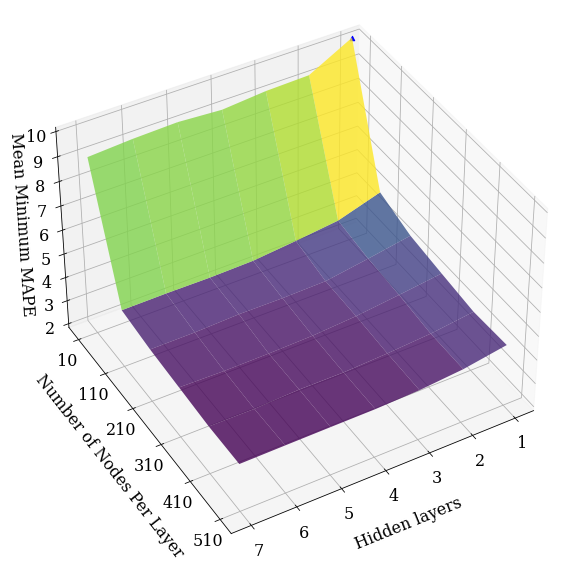

In [31]:
matplotlib.rcParams.update({'legend.fontsize': 16})
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

ax.plot_surface(num_layers,layer_sizes_array,min_mape_mean,cmap = 'viridis', alpha = 0.8)
ax.scatter3D(2,10,min_mape_mean[0,0], color = 'blue',marker = '^', alpha = 1)
#ax.scatter3D(3,18,min_mape_mean[3,3])
ax.view_init(40,60)
ax.set_xlabel('Hidden layers')
ax.set_ylabel('Number of Nodes Per Layer')
ax.set_zlabel('Mean Minimum MAPE')
ax.set_zlim(2,10)
ax.set_yticks(range(10,610,100))
ax.yaxis.labelpad =15
ax.xaxis.labelpad =15
ax.set_xticks(range(2,9))
ax.set_xticklabels(range(1,8))

In [ ]:
fig.savefig('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Figures/layer_testinf_figure1-7_10-510.png',dpi = 300)

In [ ]:
print('Optimised Layers =',num_layers[min_index],'Optimised Neuron_count= ', layer_sizes_array[min_index])
print('min_mae = ',np.min(min_mape_mean))

Optimised Layers = [7.] Optimised Neuron_count=  [410.]
min_mae =  3.849441394774271


In [23]:
min_mape , layers, layer_sizes, histories, last_value = layers_tester((360,510),10,(7,7),10, epochs = 100)

KeyboardInterrupt: 

In [17]:
mape_path = '/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Sean_Working_Notebooks/Testing_Notebooks/Testing_Data/Layer_Testing/layer_testing_7-7_layers_360-510_neurons_mape.csv'
layers_sizes_path = '/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Sean_Working_Notebooks/Testing_Notebooks/Testing_Data/Layer_Testing/layer_testing_7-7_layers_360-510_neurons_layer_sizes.csv'
[min_mape, layer_sizes, layers,bool] = data_loader(mape_path,10,path_layer_sizes= layers_sizes_path)

In [18]:
layer_sizes.shape
min_mape.shape

(16, 1, 10)

In [ ]:
'''min_mape_2d = np.reshape(min_mape,(min_mape.shape[0],min_mape.shape[1]*min_mape.shape[2]))
np.savetxt('layer_testing_'+str(layers)+'_layers_'+str(layer_sizes[0])+'-'+str(layer_sizes[-1])+'_neurons_mape.csv',min_mape_2d,delimiter=',')
#np.savetxt('layer_testing_7_layers_360-460_neurons_layers.csv',layers,delimiter=',')
np.savetxt('layer_testing_'+str(layers)+'_layers_'+str(layer_sizes[0])+'-'+str(layer_sizes[-1])+'_neurons_layer_sizes.csv',layer_sizes,delimiter=',')
np.savetxt('layer_testing_'+str(layers)+'_layers_'+str(layer_sizes[0])+'-'+str(layer_sizes[-1])+'_neurons_bool.csv',last_value,delimiter=',')'''
'''min_mape_2d =np.loadtxt('layer_testing_'+str(layers)+'_layers_'+str(layer_sizes[0])+'-'+str(layer_sizes[-1])+'_neurons_mape.csv',delimiter=',')
layers = np.loadtxt('layer_testing_'+str(layers)+'_layers_'+str(layer_sizes[0])+'-'+str(layer_sizes[-1])+'_neurons_layers.csv',delimiter=',')
layer_sizes = np.loadtxt('layer_testing_7_layers_360-460_neurons_layer_sizes.csv',delimiter=',')
last_value = np.loadtxt('layer_testing_7_layers_360-460_neurons_bool.csv',delimiter=',')'''

In [ ]:
#min_mape = min_mape_2d.reshape(min_mape_2d.shape[0],min_mape_2d.shape[1]//10,10)

In [21]:
mean_min_mape = np.mean(min_mape,axis = 2)
ste_min_mape = np.std(min_mape,axis= 2)/min_mape.shape[2]**0.5
ste_min_mape.shape
layer_sizes.shape

(16,)

([<matplotlib.axis.XTick at 0x7fbae019db80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

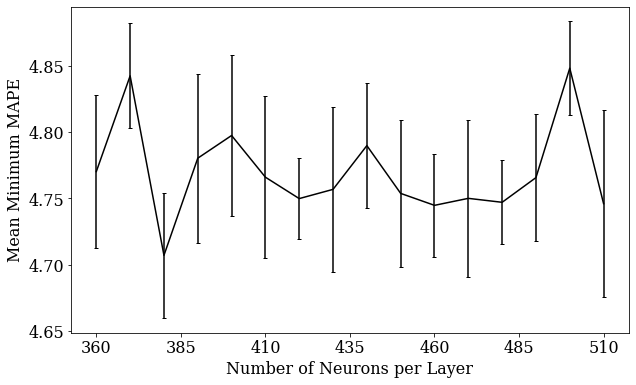

In [37]:
fig_4 = plt.figure(figsize=(10,6))
plt.errorbar(layer_sizes, mean_min_mape[:,0],ste_min_mape[:,0],c = 'black', capsize=2)
plt.xlabel('Number of Neurons per Layer')
plt.ylabel('Mean Minimum MAPE')
plt.xticks(np.linspace(layer_sizes[0],layer_sizes[-1], num = 7,dtype= int))

In [38]:
fig_4.savefig('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Figures/6hiddenlayers.png',dpi = 200)